# Spline basis with real data

In [1]:
import autograd.numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from ml_uncertainty.model_inference import ParametricModelInference
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import pandas as pd

## Real data

In [2]:
# Import wage data.
wage_data = pd.read_csv("https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/refs/heads/master/Notebooks/Data/Wage.csv", header=0, index_col=0)

In [3]:
wage_data.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


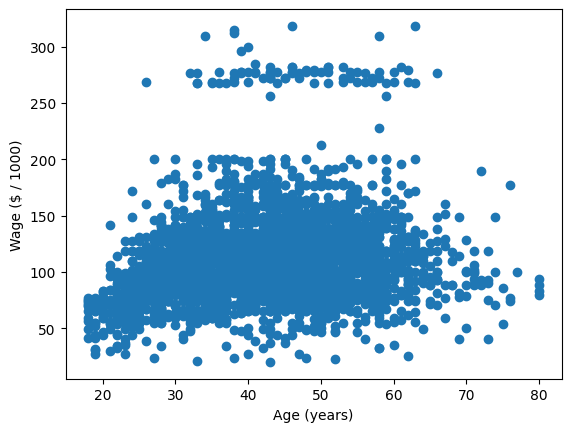

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Age (years)")
ax.set_ylabel("Wage ($ / 1000)")
ax.scatter(wage_data["age"], wage_data["wage"], label="Wage")

In [5]:
# Let's say we wish to model a relationship between Age and Wage from the data. Clearly, this cannot be done via 
# a linear model. Even a quadratic or cubic model might not suffice. A spline basis model might provide a good representation.
age = wage_data["age"].values.reshape(-1, 1)
wage = wage_data["wage"].values

# Let's create a spline representation for this. 
spline = SplineTransformer(n_knots=4, degree=3, knots="quantile", include_bias=False)

# Let's use the linear regression model for this.
linear_model = LinearRegression()

# Make and fit pipeline.
pipeline = make_pipeline(
    spline, linear_model
)

pipeline.fit(age, wage)

# Get wage predictions.
# Here, since we deal with real data, the age values are not sorted and there may be repeats. To avoid this,
# we recreate age variable.
age_pred = np.linspace(age[:, 0].min(), age[:, 0].max(), 50, endpoint=True).reshape(-1, 1)
wage_pred = pipeline.predict(age_pred)

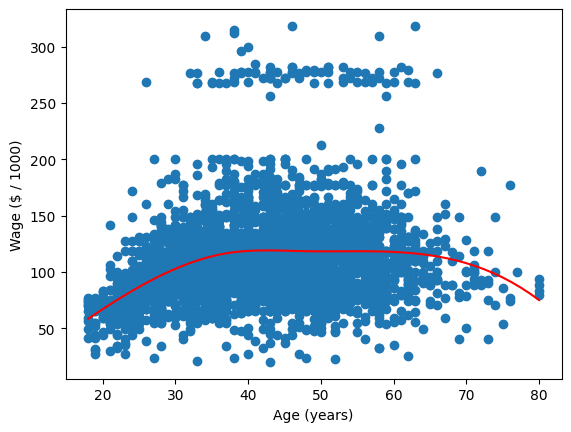

In [6]:
# Compare the predicted wage with actual data to make sure that it makes sense. 
ax.plot(age_pred[:, 0], wage_pred, linestyle="-", color="red", label="Wage predicted")
fig

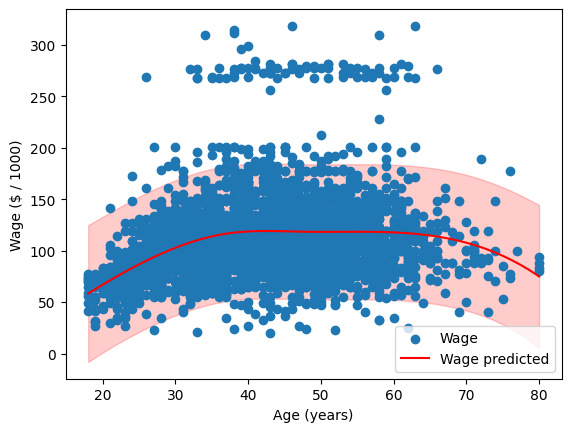

In [8]:
# Now, we can predict the uncertainty in parameters and prediction intervals using the standard ML uncertainty workflow.
inf = ParametricModelInference()
inf.set_up_model_inference(X_train=pipeline[0].transform(age), 
                               y_train=wage, estimator=linear_model)

# Get prediction intervals on the features.
df_feature_imp = inf.get_parameter_errors()

# Getting prediction intervals for X_expt values.
df_int = inf.get_intervals(pipeline[0].transform(age_pred))

# Add error bars from the package.
ax.fill_between(
    age_pred[:, 0],
    df_int["lower_bound"],
    df_int["upper_bound"],
    color="red",
    alpha=0.2,
    zorder=0,
)
ax.legend(loc="lower right")
fig

### Extension
With spline representations, a lot of complex relationships can be modelled. The ability of it to be expressed as a linear system
allows us to exploit all the properties of linear regression and consequently, allow us to estimate uncertainty and utilize other statistics.

Another great advantage of having ML Uncertainty integrated with SKLearn is that one can leverage the cross-validaton capabilities.

For instance, in this case, the choice of `n_knots=4` is somewhat arbitrary; we are forcing the system to consider only 4 knots. But is this the best decision? We could use more knots, but then the function would become too flexible. The optimum might be to use a smoothing spline; i.e., a spline with many knots and basis functions, and some penalization; say Ridge Regression. 

We can then use the `RidgeCV` model to perform cross-validation and obtain the optimum penalization. 